### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import gray2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K


from typeguard import typechecked
from typing import Optional

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [4]:
train_dataset  = train_datagen.flow_from_directory(directory = './skinlesions/train/',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

Found 1602 images belonging to 3 classes.


In [5]:
valid_dataset = valid_datagen.flow_from_directory(directory = './skinlesions/valid/',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 29 images belonging to 3 classes.


In [6]:
test_dataset = test_datagen.flow_from_directory(directory = './skinlesions/test/',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 600 images belonging to 3 classes.


## feature preprocessing and label encoding.

### MODEL BUILDING

In [7]:
base_model = MobileNet(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

17225924/17225924 [==============================] - 50s 3us/step


In [8]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [9]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(3,activation='softmax'))

In [10]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 7, 7, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 batch_normalization (BatchN  (None, 50176)            200704    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 64)                3211328   
                                                                 
 batch_normalization_1 (Batc  (None, 64)               2

In [11]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [12]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [13]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) # when i run it for 50 epochs

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

In [15]:
history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 20,
                        verbose = 1,
                         callbacks=lr_scheduler)

Epoch 1/20
51/51 [==============================] - 71s 1s/step - loss: 0.9213 - accuracy: 0.7626 - precision: 0.6721 - recall: 0.5618 - auc: 0.7647 - f1_score: 0.6039 - val_loss: 1.8968 - val_accuracy: 0.6782 - val_precision: 0.5172 - val_recall: 0.5172 - val_auc: 0.7491 - val_f1_score: 0.5172 - lr: 0.0100
Epoch 2/20
51/51 [==============================] - 50s 967ms/step - loss: 0.8373 - accuracy: 0.7853 - precision: 0.6822 - recall: 0.6660 - auc: 0.8005 - f1_score: 0.6737 - val_loss: 0.9943 - val_accuracy: 0.6782 - val_precision: 0.5172 - val_recall: 0.5172 - val_auc: 0.8109 - val_f1_score: 0.5172 - lr: 0.0063
Epoch 3/20
51/51 [==============================] - 49s 948ms/step - loss: 0.8269 - accuracy: 0.7888 - precision: 0.6866 - recall: 0.6742 - auc: 0.8076 - f1_score: 0.6862 - val_loss: 0.8942 - val_accuracy: 0.6782 - val_precision: 0.5172 - val_recall: 0.5172 - val_auc: 0.7982 - val_f1_score: 0.5172 - lr: 0.0040
Epoch 4/20
51/51 [==============================] - 49s 955ms/step 

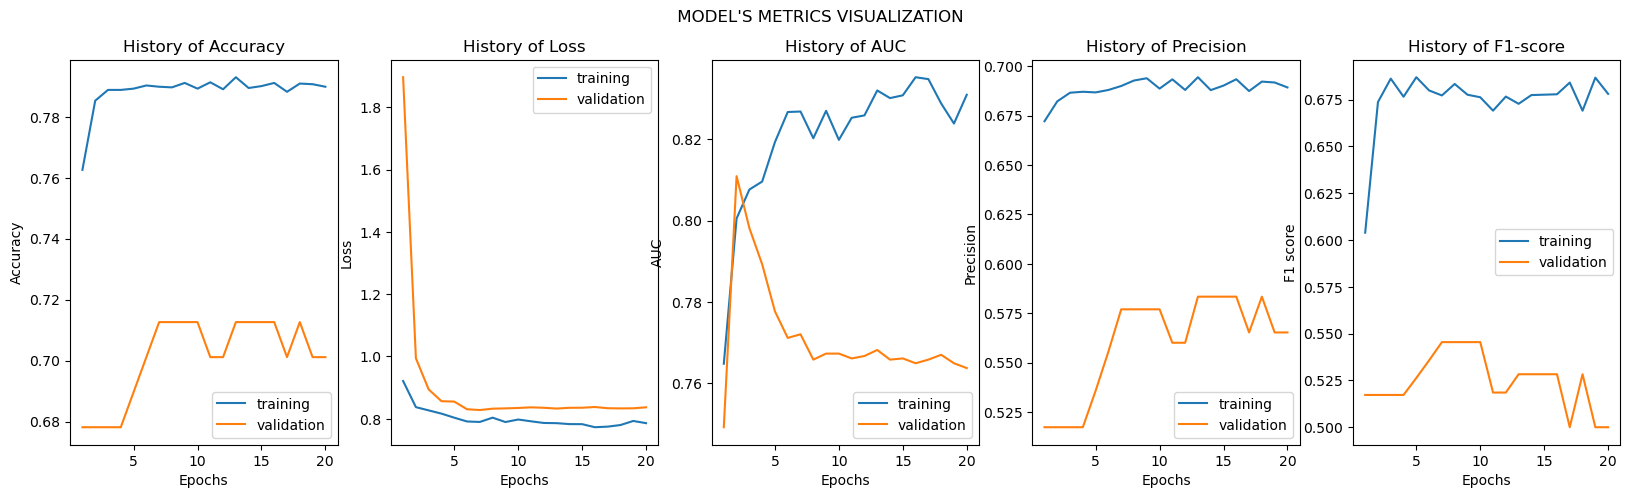

In [16]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [17]:
scores = model.evaluate(test_dataset)

19/19 [==============================] - 8s 436ms/step - loss: 0.8713 - accuracy: 0.7839 - precision: 0.7097 - recall: 0.5950 - auc: 0.8094 - f1_score: 0.6474


In [18]:
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

Accuracy =  0.7838888764381409
Precision =  0.7097415328025818
Recall =  0.5950000286102295
AUC =  0.8093819618225098
F1_score =  0.6474266648292542
